In [1]:
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN

Using TensorFlow backend.


In [2]:
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from matplotlib import pyplot
import pickle
from keras.models import load_model

In [3]:
filename = input('Enter filename to test: ')
image = Image.open(filename)
image = image.convert('RGB')
# convert to array
pixels = asarray(image)
# create the detector, using default weights
detector = MTCNN()
# detect faces in the image
results = detector.detect_faces(pixels)
# extract the bounding box from the first face
x1, y1, width, height = results[0]['box']
# bug fix
x1, y1 = abs(x1), abs(y1)
x2, y2 = x1 + width, y1 + height
# extract the face
face = pixels[y1:y2, x1:x2]
# resize pixels to the model size
image = Image.fromarray(face)
image = image.resize((160, 160))
face_array = asarray(image)

Enter filename to test: 3.jpg


In [4]:
face_array.shape

(160, 160, 3)

In [5]:
model = load_model('facenet_keras.h5')
class_model = pickle.load(open('svm_trained_classifier.pkl', 'rb'))

C:\Users\samkit\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [6]:
def get_embedding(model, face_pixels):
    # scale pixel values
    face_pixels = face_pixels.astype('float32')
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # transform face into one sample
    samples = expand_dims(face_pixels, axis=0)
    # make prediction to get embedding
    yhat = model.predict(samples)
    return yhat[0]

In [7]:
test = list()
face_pixels = face_array
embedding = get_embedding(model, face_pixels)
test.append(embedding)
test = asarray(test)
# print(test.shape)

In [8]:
# normalize input vectors
in_encoder = Normalizer(norm='l2')
test = in_encoder.transform(test)

In [9]:
# load faces
data = load('faces-dataset.npz')
testX_faces = data['arr_2']
# load face embeddings
data = load('faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)

In [10]:
random_face_emb = test

In [11]:
random_face_emb = random_face_emb.reshape((128,))
# print(random_face_emb)

In [12]:
# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
# print(samples)
# print(samples.shape)
yhat_class = class_model.predict(samples)
yhat_prob = class_model.predict_proba(samples)

In [29]:
# get name
class_index = yhat_class
class_probability = yhat_prob * 100
predict_names = out_encoder.inverse_transform(yhat_class)
# print(predict_names)
print('Predicted: ',predict_names,' (',str(class_probability[0])[1:7],')')

Predicted:  ['Samkit Saraf']  ( 95.815 )


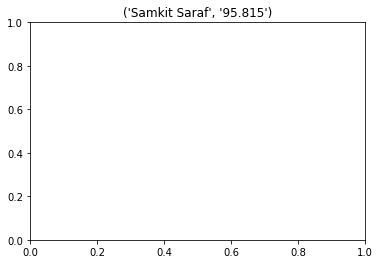

In [33]:
# pyplot.imshow(face_array)
title = predict_names[0],str(class_probability[0])[1:7]
pyplot.title(title)
pyplot.show()